In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time

from recommenders.datasets import movielens
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from lightgbm import LGBMRegressor

In [3]:
# Tải dữ liệu
df = movielens.load_pandas_df(
    size="100k",
    header=["userId", "movieId", "rating", "timestamp"]
)
df = df[["userId", "movieId", "rating"]]
print(df.head())

100%|██████████| 4.81k/4.81k [00:06<00:00, 741KB/s]  


   userId  movieId  rating
0     196      242     3.0
1     186      302     3.0
2      22      377     1.0
3     244       51     2.0
4     166      346     1.0


In [4]:
# ma hoa
user_enc = LabelEncoder()
item_enc = LabelEncoder()
df["userId_enc"] = user_enc.fit_transform(df["userId"])
df["movieId_enc"] = item_enc.fit_transform(df["movieId"])

In [5]:
# Chuẩn hóa
scaler = StandardScaler()
df[["userId_enc", "movieId_enc"]] = scaler.fit_transform(df[["userId_enc", "movieId_enc"]])

df.head()

,userId,movieId,rating,userId_enc,movieId_enc
0,196,242,3.0,-0.999519,-0.554812
1,186,302,3.0,-1.037026,-0.373432
2,22,377,1.0,-1.652150,-0.146707
3,244,51,2.0,-0.819482,-1.132206
4,166,346,1.0,-1.112041,-0.240420


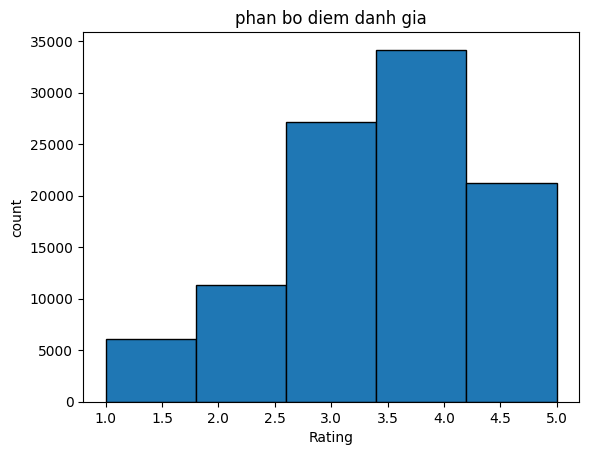

In [6]:
plt.hist(df['rating'], bins = 5, ec = 'black')
plt.xlabel('Rating')
plt.ylabel('count')
plt.title('phan bo diem danh gia')
plt.show()

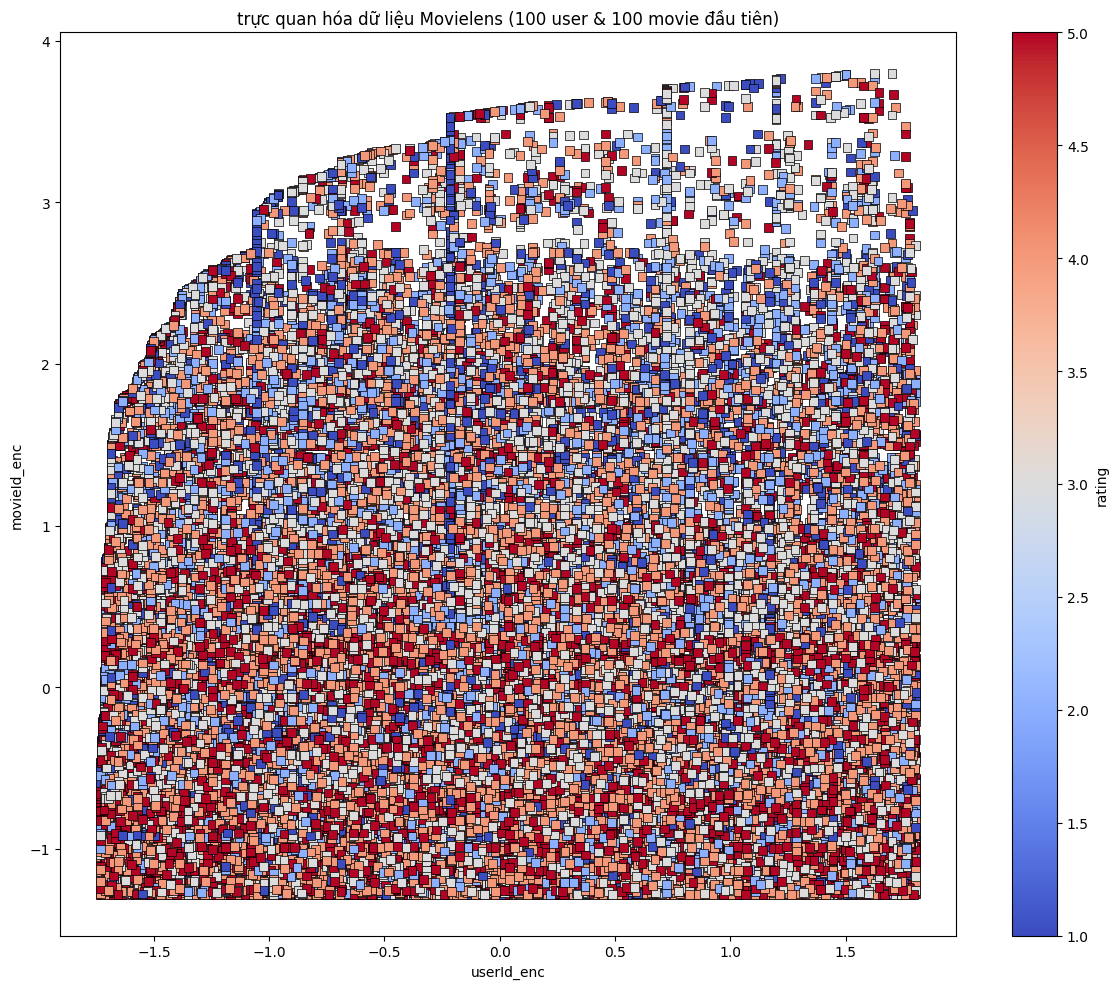

In [7]:
filtered_df = df[
    (df['userId_enc'] <= 100) &
    (df['movieId_enc'] <= 100)
]

plt.figure(figsize = (12,10))
plt.scatter(filtered_df['userId_enc'], filtered_df['movieId_enc'],
            c = filtered_df['rating'], cmap = 'coolwarm', s = 40, marker = 's', edgecolors = 'black',
            linewidths = 0.5)
plt.colorbar(label = 'rating')
plt.title("trực quan hóa dữ liệu Movielens (100 user & 100 movie đầu tiên)")
plt.xlabel("userId_enc")
plt.ylabel("movieId_enc")
plt.tight_layout()
plt.show()

In [8]:
#xao tron du lieu
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [9]:
X = df[["userId_enc", "movieId_enc"]]
y = df["rating"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
#huấn luyện mô hình với bộ tham số mặc định
model = LGBMRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 509
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 2
[LightGBM] [Info] Start training from score 3.530387


In [11]:
# danh gia model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")

MAE: 0.822
MSE: 1.047
RMSE: 1.023


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 509
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 2
[LightGBM] [Info] Start training from score 3.530362
Lần 1: RMSE = 1.029 | MAE = 0.828  | MSE = 1.058
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 509
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 2
[LightGBM] [Info] Start training from score 3.530413
Lần 2: RMSE = 1.029 | MAE = 0.829  | MSE = 1.059
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_col_wise=true` to remove the overhe

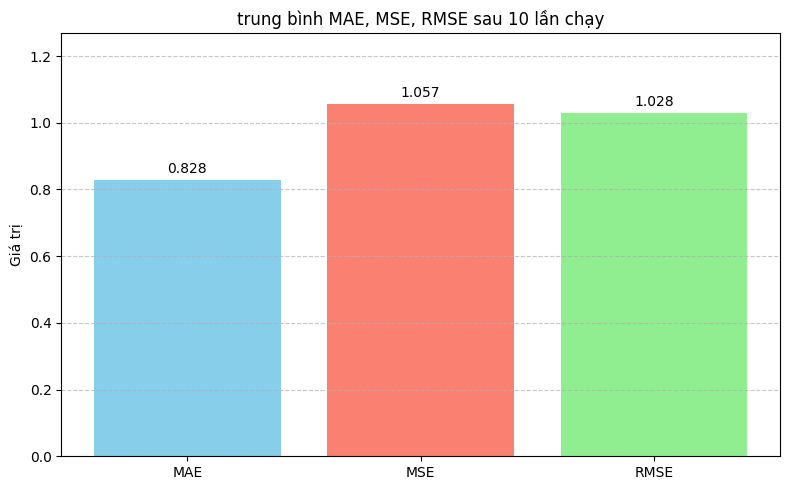

In [ ]:
#chạy thực nghiệm 10 lần bộ tham số mặc định
rmse_list = []
mae_list = []
mse_list = []
time_train = []
time_test = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=i
    )
    st = time.time()
    model = LGBMRegressor()
    model.fit(X_train, y_train)
    et = time.time() - st
    time_train.append(et)

    st = time.time()
    y_pred = model.predict(X_test)
    et = time.time() - st
    time_test.append(et)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    
    print(f"Lần {i+1}: RMSE = {rmse:.3f} | MAE = {mae:.3f}  | MSE = {mse:.3f}")

mean_mae = np.mean(mae_list)
mean_mse = np.mean(mse_list)
mean_rmse = np.mean(rmse_list)

print(f"\nTrung bình sau 10 lần:")
print(f"MAE trung bình: {mean_mae:.3f}")
print(f"MSE trung bình: {mean_mse:.3f}")
print(f"RMSE trung bình: {mean_rmse:.3f}")

Ketqua_timeTrain = np.mean(time_train)
print(f"timeTrain: {Ketqua_timeTrain:.4f}")
Ketqua_timeTest = np.mean(time_test)
print(f"timeTest: {Ketqua_timeTest:.4f}")

# Danh sách metric và giá trị trung bình tương ứng
metrics = ['MAE', 'MSE', 'RMSE']
values = [mean_mae, mean_mse, mean_rmse]

# Tạo biểu đồ
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(metrics, values, color=['skyblue', 'salmon', 'lightgreen'])

# Thêm nhãn, tiêu đề
ax.set_title("trung bình MAE, MSE, RMSE sau 10 lần chạy")
ax.set_ylabel("Giá trị")
ax.set_ylim(0, max(values)*1.2)  # dư khoảng để hiển thị số trên cột
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Hiển thị giá trị trên đầu mỗi cột
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 509
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 2
[LightGBM] [Info] Start training from score 3.530362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

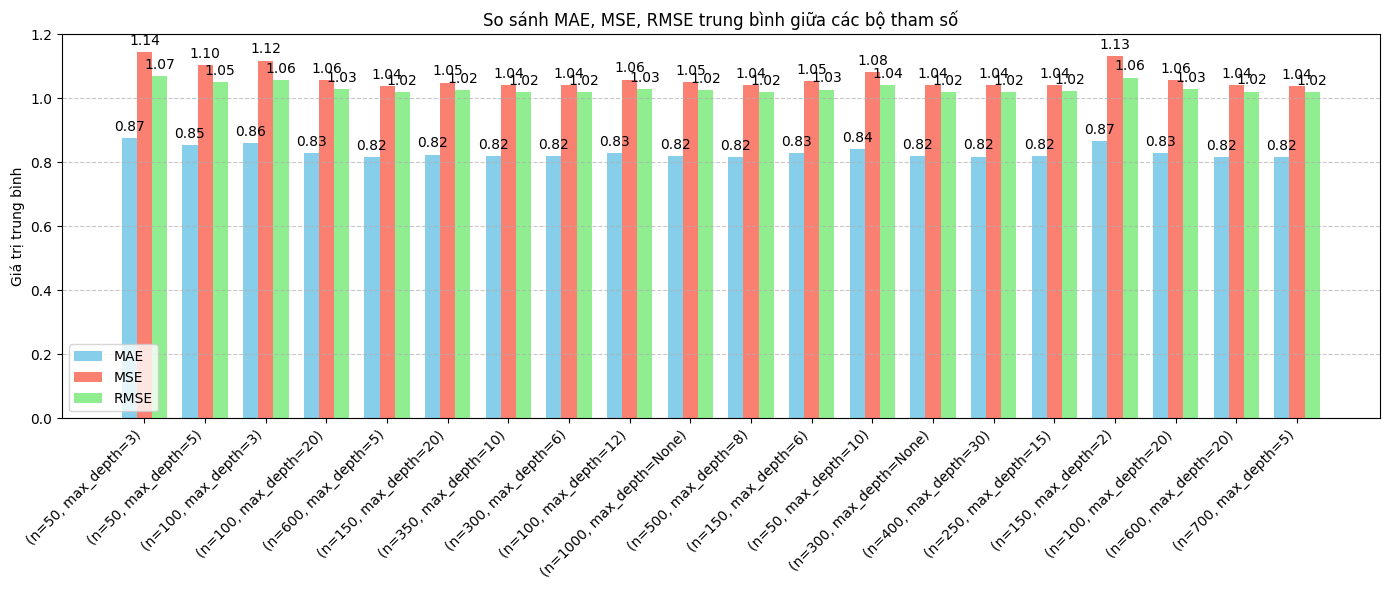

In [13]:
#chạy thực nghiệm 20 bộ tham số mỗi bộ 10 lầnlần
results = []

param_sets = [
    (50, 3),
    (50, 5),
    (100, 3),
    (100, 20),
    (600, 5),
    (150, 20),
    (350, 10),
    (300, 6),
    (100, 12),
    (1000, None),
    (500, 8),
    (150, 6),
    (50, 10),
    (300, None),
    (400, 30),
    (250, 15),
    (150, 2),
    (100, 20),
    (600, 20),
    (700, 5),
]

for idx, (n, m) in enumerate(param_sets, 1):
    rmse_list = []
    mae_list = []
    mse_list = []
    time_train = []
    time_test = []

    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=i
        )
        st = time.time()
        model = LGBMRegressor(n_estimators=n, max_depth=m)
        model.fit(X_train, y_train)
        et = time.time() - st
        time_train.append(et)

        st = time.time()
        y_pred = model.predict(X_test)
        et = time.time() - st
        time_test.append(et)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)

        mse_list.append(mse)
        rmse_list.append(rmse)
        mae_list.append(mae)

        print(f"Lần {i+1}: RMSE = {rmse:.3f} | MAE = {mae:.3f}  | MSE = {mse:.3f}")

    mean_mae = np.mean(mae_list)
    mean_mse = np.mean(mse_list)
    mean_rmse = np.mean(rmse_list)

    print(f"\nTrung bình sau 10 lần:")
    print(f"MAE trung bình: {mean_mae:.3f}")
    print(f"MSE trung bình: {mean_mse:.3f}")
    print(f"RMSE trung bình: {mean_rmse:.3f}")

    Ketqua_timeTrain = np.mean(time_train)
    print(f"timeTrain: {Ketqua_timeTrain:.4f}")
    Ketqua_timeTest = np.mean(time_test)
    print(f"timeTest: {Ketqua_timeTest:.4f}")

    # Ghi kết quả vào list
    results.append({
        'params': f"(n={n}, max_depth={m})",
        'MAE': mean_mae,
        'MSE': mean_mse,
        'RMSE': mean_rmse,
    })


# Sau khi vòng lặp hoàn tất – so sánh tổng hợp
labels = [r['params'] for r in results]
mae_values = [r['MAE'] for r in results]
mse_values = [r['MSE'] for r in results]
rmse_values = [r['RMSE'] for r in results]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 6))
rects1 = ax.bar(x - width, mae_values, width, label='MAE', color='skyblue')
rects2 = ax.bar(x, mse_values, width, label='MSE', color='salmon')
rects3 = ax.bar(x + width, rmse_values, width, label='RMSE', color='lightgreen')

ax.set_ylabel('Giá trị trung bình')
ax.set_title('So sánh MAE, MSE, RMSE trung bình giữa các bộ tham số')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

for rects in [rects1, rects2, rects3]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [15]:
with open('lightgbm_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Lưu mô hình thành công")

Lưu mô hình thành công
